# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 3: Multiple Linear Regression and Polynomial Regression 

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Sean Murphy, Yinyu Ji<br/>

<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with Multiple Linear Regression. We have learned how to model data with kNN Regression and Simple Linear Regression and our goal now is to dive deep into Linear Regression.

Specifically, we will: 
    
- Load in the titanic dataset from seaborn
- Learn a few ways to **visualize distributions** of variables using seaborn
- Practice single variable OLS and how to **interpret coefficients** in linear regression
- Practice multiple linear regression with **interaction** terms and **polynomial** regression terms
- Learn about **bootstrapping** to generate confidence intervals
- Understand the **assumptions** being made in a linear regression model
- (Bonus 1): look at some cool plots to raise your exploratory data analysis (EDA) game
- (Bonus 2): look at some example stats models code that produces equivalent results

![meme](../fig/meme.png)

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Modeling
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Extending Linear Regression

## Working with the Titanic Dataset from Seaborn

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

The task is to build a regression model to **predict the fare**, based on different attributes.

Let's keep a subset of the data, which includes the following variables: 

- age
- sex
- class
- embark_town
- alone
- **fare** (the response variable)

In [3]:
# Load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# checking for null values
chosen_vars = ['age', 'sex', 'class', 'embark_town', 'alone', 'fare']
titanic = titanic[chosen_vars]
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          714 non-null    float64 
 1   sex          891 non-null    object  
 2   class        891 non-null    category
 3   embark_town  889 non-null    object  
 4   alone        891 non-null    bool    
 5   fare         891 non-null    float64 
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB


Check the datatypes of each column and display the statistics (min, max, mean and any others) for all the numerical columns of the dataset.

In [5]:
print(titanic.dtypes)
titanic.describe()

age             float64
sex              object
class          category
embark_town      object
alone              bool
fare            float64
dtype: object


,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


Drop all the non-null *rows* in the dataset. Is this always a good idea?

In [6]:
titanic = titanic.dropna(axis=0)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          712 non-null    float64 
 1   sex          712 non-null    object  
 2   class        712 non-null    category
 3   embark_town  712 non-null    object  
 4   alone        712 non-null    bool    
 5   fare         712 non-null    float64 
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.3+ KB


Now let us visualize the response variable. A good visualization of the distribution of a variable will enable us to answer three kinds of questions:

- What values are central or typical? (e.g., mean, median, modes)
- What is the typical spread of values around those central values? (e.g., variance/stdev, skewness)
- What are unusual or exceptional values (e.g., outliers)

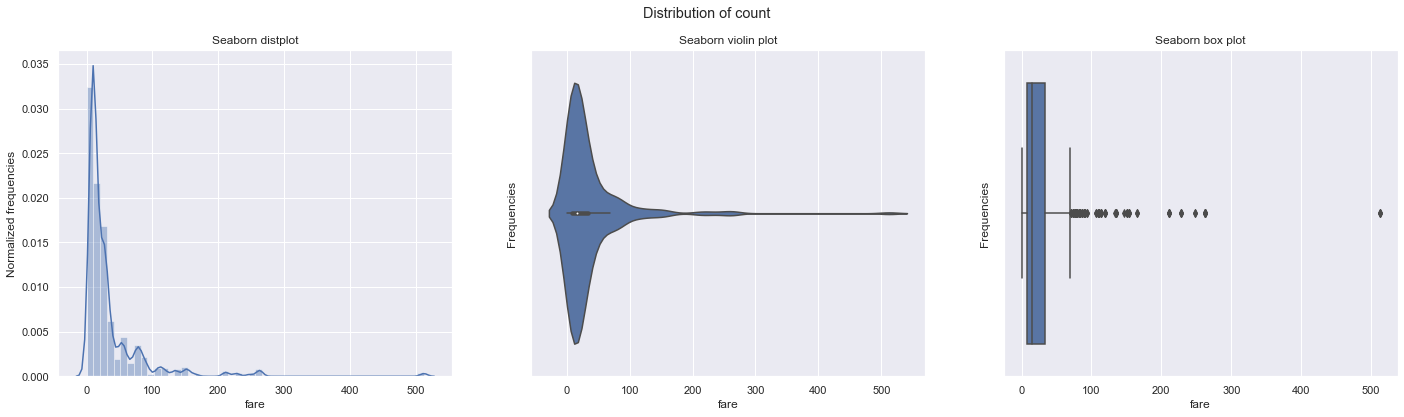

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
ax = ax.ravel()

sns.distplot(titanic['fare'], ax=ax[0])
ax[0].set_title('Seaborn distplot')
ax[0].set_ylabel('Normalized frequencies')

sns.violinplot(x='fare', data=titanic, ax=ax[1])
ax[1].set_title('Seaborn violin plot')
ax[1].set_ylabel('Frequencies')

sns.boxplot(x='fare', data=titanic, ax=ax[2])
ax[2].set_title('Seaborn box plot')
ax[2].set_ylabel('Frequencies')
fig.suptitle('Distribution of count');

How do we interpret these plots?

## Train-Test Split

#### Let's split the data into train and test sets.

In [8]:
titanic_train, titanic_test = train_test_split(titanic, train_size=0.7, random_state=42)
# important for avoiding the infamous SettingwithCopyWarning
titanic_train = titanic_train.copy()
titanic_test = titanic_test.copy()
print(titanic_train.shape, titanic_test.shape)

(498, 6) (214, 6)


## Simple One-Variable Linear Regression

#### Now, let's fit a simple model on the training data using LinearRegression from the sklearn library, predicting **fare** using **age**.

We'll call this `model_1` and take a look at its coefficient and R-squared.

In [9]:
# assign predictor and response variables
X_train = titanic_train[['age']]
y_train = titanic_train['fare']
X_test = titanic_test[['age']]
y_test = titanic_test['fare']

model_1 = LinearRegression().fit(X_train, y_train)

In [10]:
# check the slope/coefficient and intercept values
print("Coefficient of the model: ",model_1.coef_)
print("Intercept of the model: ",model_1.intercept_)

# predict on test set
y_test_pred = model_1.predict(X_test)

# get R-squared
print("R-squared of the model:", r2_score(y_test, y_test_pred))

Coefficient of the model:  [0.30719537]
Intercept of the model:  22.7657092800262
R-squared of the model: -0.010941835506851794


## Variable Types

In general, you should be able to distinguish between three kinds of variables: 

1. Continuous variables: such as `fare` or `age`
2. Categorical variables: such as `sex` or `alone`. There is no inherent ordering between the different values that these variables can take on. These are sometimes called nominal variables. Read more [here](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/). 
3. Ordinal variables: such as `class` (first > second > third). There is some inherent ordering of the values in the variables, but the values are not continuous either. 

*Note*: While there is some inherent ordering in `class`, we will be treating it like a categorical variable.

Let us now examine the `sex` column and see the value counts.

In [11]:
titanic_train['sex'].value_counts()

male      316
female    182
Name: sex, dtype: int64

Create a column `sex_male` that is 1 if the passenger is male, 0 if female. The value counts indicate that these are the two options in this particular dataset. Ensure that the datatype is `int`.

In [12]:
titanic_train['sex_male'] = (titanic_train.sex == 'male').astype(int)
titanic_train['sex_male'].value_counts()

1    316
0    182
Name: sex_male, dtype: int64

Do we need a `sex_female` column, or a `sex_others` column? Why or why not?

Now, let us look at `class` in greater detail. Let's one hot encode.

## One Hot Encoding

In [13]:
titanic_train['class_Second'] = (titanic_train['class'] == 'Second').astype(int)
titanic_train['class_Third'] = 1 * (titanic_train['class'] == 'Third') # just another way to do it

In [14]:
# do the same for the test set
titanic_test_orig = titanic_test.copy()

titanic_test = pd.get_dummies(titanic_test, columns=['sex', 'class'], drop_first=True)
titanic_test.head()

,age,embark_town,alone,fare,sex_male,class_Second,class_Third
641,24.0,Cherbourg,True,69.3000,0,0,0
496,54.0,Cherbourg,False,78.2667,0,0,0
262,52.0,Southampton,False,79.6500,1,0,0
311,18.0,Cherbourg,False,262.3750,0,0,0
551,27.0,Southampton,True,26.0000,1,1,0


## Working with binary predictors

![male_female](../fig/male_female.png)



## Linear Regression with More Variables

#### Now let's fit a linear regression including the new sex and class variables, calling this model `model_2`.

![image.png](../fig/multiple.png)

In [15]:
# assign predictor and response variables
X_train = titanic_train[['age', 'sex_male', 'class_Second', 'class_Third']]
y_train = titanic_train['fare']
X_test = titanic_test[['age', 'sex_male', 'class_Second', 'class_Third']]
y_test = titanic_test['fare']

model_2 = LinearRegression().fit(X_train, y_train)

In [16]:
# check the coefficients and intercept values
print("Coefficients of the model: ",model_2.coef_)
print("Intercept of the model: ",model_2.intercept_)

# predict on test set
y_test_pred = model_2.predict(X_test)

# get R-squared
print("R-squared of the model:", r2_score(y_test, y_test_pred))

Coefficients of the model:  [ -0.34386667 -15.39741055 -62.01751625 -69.1697639 ]
Intercept of the model:  101.45713570147439
R-squared of the model: 0.3328618178344189


### Interpreting These Results

1. Which of the predictors do you think are important? Why?
2. All else equal, what does being male do to the fare?

## Engineering Variables: Exploring Interactions

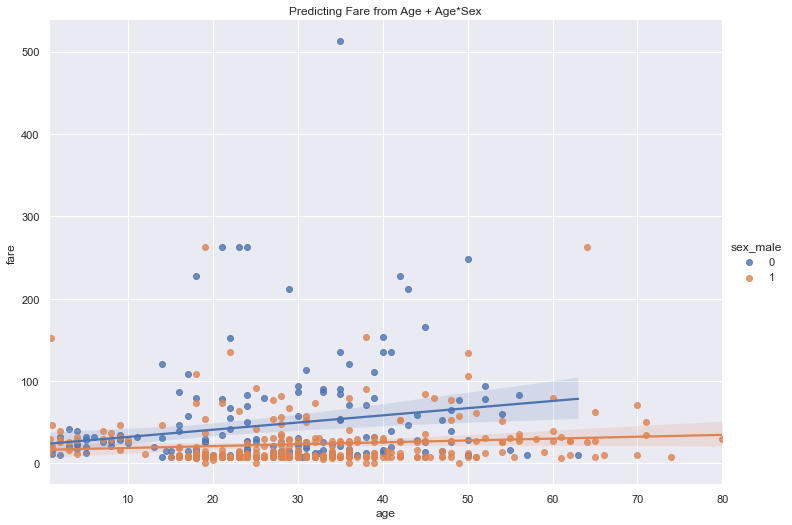

In [17]:
sns.lmplot(y = "fare", x= "age", hue = "sex_male", data = titanic_train, height=7.27, aspect=11.7/8.27)
ax = plt.gca()
ax.set_title("Predicting Fare from Age + Age*Sex")
plt.show()

The slopes seem to be different for male and female. What does that indicate?

Let us now try to add an interaction effect into our model.

In [18]:
# It seemed like sex interacted with age. Can we put that in our model?
titanic_train['sex_male_X_age'] = titanic_train['age'] * titanic_train['sex_male']
titanic_test['sex_male_X_age'] = titanic_test['age'] * titanic_test['sex_male']

X_train = titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']]
y_train = titanic_train['fare']
X_test = titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']]
y_test = titanic_test['fare']

model_3 = LinearRegression().fit(X_train, y_train)

In [19]:
# check the coefficients and intercept values
print("Coefficients of the model: ",model_3.coef_)
print("Intercept of the model: ",model_3.intercept_)

# predict on test set
y_test_pred = model_3.predict(X_test)

# get R-squared
print("R-squared of the model:", r2_score(y_test, y_test_pred))

Coefficients of the model:  [  0.09558632   2.65944892 -62.41822928 -68.9649407   -0.63896115]
Intercept of the model:  89.65080026341082
R-squared of the model: 0.3317269706904564


In [20]:
# It seemed like sex interacted with class. Can we put that in our model?
titanic_train['sex_male_X_class_Second'] = titanic_train['age'] * titanic_train['class_Second']
titanic_train['sex_male_X_class_Third'] = titanic_train['age'] * titanic_train['class_Third']
titanic_test['sex_male_X_class_Second'] = titanic_test['age'] * titanic_test['class_Second']
titanic_test['sex_male_X_class_Third'] = titanic_test['age'] * titanic_test['class_Third']

X_train = titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                         'sex_male_X_class_Second', 'sex_male_X_class_Third']]
y_train = titanic_train['fare']
X_test = titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age',
                      'sex_male_X_class_Second', 'sex_male_X_class_Third']]
y_test = titanic_test['fare']

model_4 = LinearRegression().fit(X_train, y_train)

In [21]:
# check the coefficients and intercept values
print("Coefficients of the model: ",model_4.coef_)
print("Intercept of the model: ",model_4.intercept_)

# predict on test set
y_test_pred = model_4.predict(X_test)

# get R-squared
print("R-squared of the model:", r2_score(y_test, y_test_pred))

Coefficients of the model:  [ -0.43054635   1.11529339 -86.51871324 -92.29906228  -0.56521793
   0.67030334   0.67297463]
Intercept of the model:  108.97289238827835
R-squared of the model: 0.34990440270209267


**What happened to the `age` and `male` terms?**

# Prepare for Breakout Room 1

**Boston Housing Prices Dataset**

Data Description:
- RM: Average number of rooms per dwelling
- LSTAT: Percent of housing population classified as "lower status"
- MEDV: Median value of owner-occupied homes in $1000's

MEDV will be the response variable

(For the curious: https://www.kaggle.com/c/boston-housing)


Load and inspect the data

In [22]:
boston = pd.read_csv('../data/boston_housing.csv')
boston.head()

,RM,LSTAT,MEDV
0,6.575,4.98,24.0
1,6.421,9.14,21.6
2,7.185,4.03,34.7
3,6.998,2.94,33.4
4,7.147,5.33,36.2


Inspect data by visualization (we can combine matplotlib with seaborn)

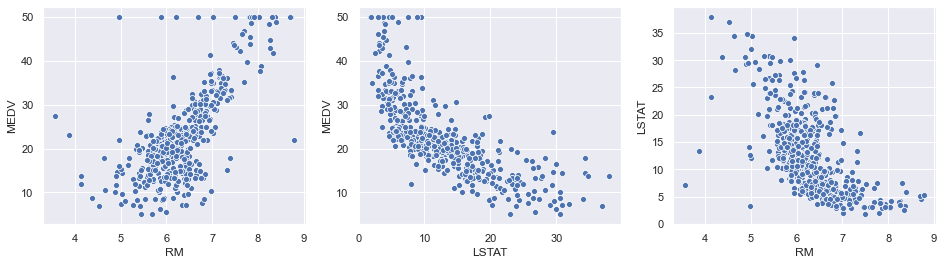

In [23]:
plt.figure(figsize=[16,4])
plt.subplot(1,3,1)
sns.scatterplot(x="RM", y="MEDV", data=boston)
plt.subplot(1,3,2)
sns.scatterplot(x="LSTAT", y="MEDV", data=boston)
plt.subplot(1,3,3)
sns.scatterplot(x="RM", y="LSTAT", data=boston);


Split the data and perform single variable linear regression with the predictors RM and LSTAT 

In [24]:
boston_train, boston_test = train_test_split(boston, train_size=0.7, random_state=109)

# Single variable linear regression with RM
model_boston_0a = LinearRegression().fit(boston_train[["RM"]], boston_train.MEDV)
print("R^2 on training set of the model with RM:",  r2_score(boston_train.MEDV, model_boston_0a.predict(boston_train[["RM"]])) )
print("R^2 on testing  set of the model with RM:",  r2_score(boston_test.MEDV, model_boston_0a.predict(boston_test[["RM"]])) )
print('')

# Single variable linear regression with RM
model_boston_0b = LinearRegression().fit(boston_train[["LSTAT"]], boston_train.MEDV)
print("R^2 on training set of the model with LSTAT:",  r2_score(boston_train.MEDV, model_boston_0b.predict(boston_train[["LSTAT"]])) )
print("R^2 on testing set  of the model with LSTAT:",  r2_score(boston_test.MEDV, model_boston_0b.predict(boston_test[["LSTAT"]])) )

# Store R2 on testing for later
R2_0a = r2_score(boston_test.MEDV, model_boston_0a.predict(boston_test[["RM"]])) 
R2_0b = r2_score(boston_test.MEDV, model_boston_0b.predict(boston_test[["LSTAT"]])) 

R^2 on training set of the model with RM: 0.4894044654051818
R^2 on testing  set of the model with RM: 0.463726565512551

R^2 on training set of the model with LSTAT: 0.5338061840518573
R^2 on testing set  of the model with LSTAT: 0.5647466516808153


# Time for Breakout Room 1

**Goal**: Learn about how to include interaction terms in your linear regression model using the sklearn library.  

**Directions:**
    1. Build an linear regression model using `RM` and `LSTAT` as predictors.
        - As before, fit the model on the training data.
        - Print the coefficients.
        - Report the R^2 score on the test data. Did the performance improve?
        - Does the multiple regression model perform better than the two single regression models?
    2. Build a model with `LSTAT`, `RM`, and an interaction term between `LSTAT` and `RM`
        - Print the coefficients.
        - Does the interaction term improve R^2?
        
    Store R^2 on testing sets for later investigation. 

In [25]:
# %load ../solutions/breakout_1_sol.py

## Multiple regression
model_boston_1 = LinearRegression().fit(boston_train[["LSTAT", "RM"]], boston_train.MEDV)
print('Coefficients: ', model_boston_1.coef_)
print("R^2 on testing set  of the multiple regression model: ",  r2_score(boston_test.MEDV, model_boston_1.predict(boston_test[["LSTAT","RM"]])) )
print(' ')

## Multiple regression including Interaction Term

# Data engineering to include interaction term as a new predictor (feature)
boston["LSTAT*RM"] = boston["LSTAT"]*boston["RM"]
boston_train, boston_test = train_test_split(boston, train_size=0.7, random_state=42)

model_boston_1_inter = LinearRegression().fit(boston_train[["LSTAT", "RM", "LSTAT*RM"]], boston_train.MEDV)
print('Coefficients: ', model_boston_1_inter.coef_)
print("R^2 on testing set of the model including interaction:", r2_score(boston_test.MEDV, model_boston_1_inter.predict(boston_test[["LSTAT", "RM", "LSTAT*RM"]])))

# When do we want an interaction term with two continous variables?
# Answer: If we ask, “What is the effect of LSTAT on MEDV”, and the answer is “it depends on what RM equals.”
# https://www3.nd.edu/~rwilliam/stats2/l55.pdf

#Store R^2 for later investigation
R2_1 =  r2_score(boston_test.MEDV, model_boston_1.predict(boston_test[["LSTAT","RM"]]))
R2_1_inter = r2_score(boston_test.MEDV, model_boston_1_inter.predict(boston_test[["LSTAT", "RM", "LSTAT*RM"]]))


Coefficients:  [-0.62505109  5.32989013]
R^2 on testing set  of the multiple regression model:  0.6407660364619081
 
Coefficients:  [ 2.1321553   9.56301377 -0.47503991]
R^2 on testing set of the model including interaction: 0.7209758687120075


## Engineering Variables: Exploring Polynomial Regression 

![poly](../fig/poly.png)

Perhaps we now believe that the fare also depends on the square of age. How would we include this term in our model?

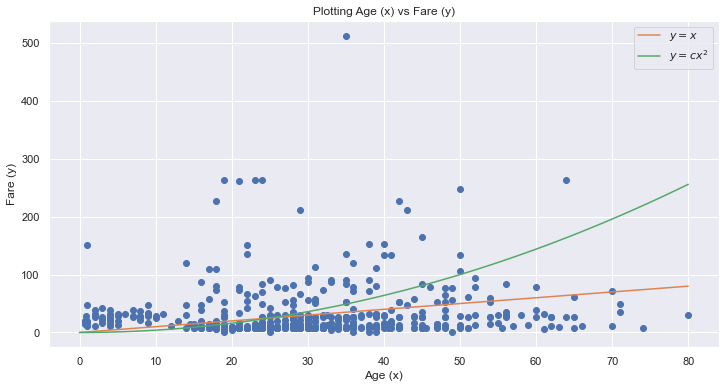

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(titanic_train['age'], titanic_train['fare'], 'o')
x = np.linspace(0,80,100)
ax.plot(x, x, '-', label=r'$y=x$')
ax.plot(x, 0.04*x**2, '-', label=r'$y=c x^2$')
ax.set_title('Plotting Age (x) vs Fare (y)')
ax.set_xlabel('Age (x)')
ax.set_ylabel('Fare (y)')
ax.legend();

Create a model that predicts fare from all the predictors in `model_4` + the square of age. Show the summary of this model. Call it `model_5`. Remember to use the training data, `titanic_train`.

In [27]:
titanic_train['age^2'] = titanic_train['age']**2
titanic_test['age^2'] = titanic_test['age']**2

X_train = titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third', 'age^2']]
y_train = titanic_train['fare']
X_test = titanic_test[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third', 'age^2']]
y_test = titanic_test['fare']

model_5 = LinearRegression().fit(X_train, y_train)

In [28]:
# check the coefficients and intercept values
print("Coefficients of the model: ",model_5.coef_)
print("Intercept of the model: ",model_5.intercept_)

# predict on test set
y_test_pred = model_5.predict(X_test)

# get R-squared
print("R-squared of the model:", r2_score(y_test, y_test_pred))

Coefficients of the model:  [-1.47514434e+00  6.60879191e+00 -9.52689691e+01 -1.03521625e+02
 -7.60060109e-01  9.12668509e-01  1.02048821e+00  1.46235617e-02]
Intercept of the model:  125.99161699924736
R-squared of the model: 0.34560304513369544


# Time for Breakout Room 2

**Goal**: Learn about how to include polynomial terms in your model. 

**Directions:**

In all the cases print the coefficients and report the R^2 in testing: 

    1. Build a polynomial regression model including the 2nd degree terms of both `LSTAT` and `RM` 
    2. Next, include the interaction term between `LSTAT` and `RM` in your model
    3. Finally, include the 3rd degree terms of both `LSTAT` and `RM` in your model
      
Can you see any improvement? Reviewing the models you have built thus far, which one would you choose and why? 


In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
boston.head()

,RM,LSTAT,MEDV,LSTAT*RM
0,6.575,4.98,24.0,32.74350
1,6.421,9.14,21.6,58.68794
2,7.185,4.03,34.7,28.95555
3,6.998,2.94,33.4,20.57412
4,7.147,5.33,36.2,38.09351


In [31]:
boston['LSTAT^2'] = boston['LSTAT']**2
boston['RM^2'] = boston['RM']**2
boston.head()


,RM,LSTAT,MEDV,LSTAT*RM,LSTAT^2,RM^2
0,6.575,4.98,24.0,32.74350,24.8004,43.230625
1,6.421,9.14,21.6,58.68794,83.5396,41.229241
2,7.185,4.03,34.7,28.95555,16.2409,51.624225
3,6.998,2.94,33.4,20.57412,8.6436,48.972004
4,7.147,5.33,36.2,38.09351,28.4089,51.079609


In [32]:
xtrain, xtest = train_test_split(boston, train_size = 0.75, random_state=1)

In [33]:
ytrain = xtrain['MEDV']
ytest = xtest['MEDV']

In [34]:
predictors = xtrain[['RM', 'LSTAT', 'LSTAT^2', 'RM^2']]

In [35]:
testers = xtest[['RM', 'LSTAT', 'LSTAT^2', 'RM^2']]

In [36]:
model = LinearRegression().fit(predictors, ytrain)

In [37]:
r2_score(ytest, model.predict(testers))

0.8232407496431767

In [38]:
# %load ../solutions/breakout_2_sol.py

# Data engineering to include polynomial terms as predictors (features)
boston["LSTAT**2"] = boston["LSTAT"]**2
boston["LSTAT**3"] = boston["LSTAT"]**3
boston["RM**2"] = boston["RM"]**2
boston["RM**3"] = boston["RM"]**3
boston_train, boston_test = train_test_split(boston, train_size=0.7, random_state=42)


# Regression with 2nd order terms
model_boston_2 = LinearRegression().fit(boston_train[["LSTAT", "RM",  "LSTAT**2",  "RM**2"]], boston_train.MEDV)
R2_2= r2_score(boston_test.MEDV, model_boston_2.predict(boston_test[["LSTAT", "RM", "LSTAT**2",  "RM**2"]]))
print('Coefficients: ', model_boston_2.coef_)
print("R^2 on testing set including 2nd order terms:", R2_2)


# Regression with 2nd order terms including interaction term
print(' ')
model_boston_2_inter = LinearRegression().fit(boston_train[["LSTAT", "RM",  "LSTAT**2",  "RM**2", "LSTAT*RM"]], boston_train.MEDV)
R2_2_inter= r2_score(boston_test.MEDV, model_boston_2_inter.predict(boston_test[["LSTAT", "RM", "LSTAT**2",  "RM**2","LSTAT*RM"]]))
print('Coefficients: ', model_boston_2_inter.coef_)
print("R^2 on testing set including 2nd order terms:", R2_2_inter)


# Regression with 3nd order terms including interaction term
print(' ')
model_boston_3_inter = LinearRegression().fit(
        boston_train[["LSTAT", "RM",  "LSTAT**2",  "RM**2","RM**3", "LSTAT**3", "LSTAT*RM"]], boston_train.MEDV)
R2_3_inter= r2_score(boston_test.MEDV, model_boston_3_inter.predict(
        boston_test[["LSTAT", "RM", "LSTAT**2",  "RM**2","RM**3", "LSTAT**3", "LSTAT*RM"]]))
print('Coefficients: ', model_boston_3_inter.coef_)
print("R^2 on testing set including 2nd order terms:", R2_3_inter)



Coefficients:  [-1.53629773e+00 -2.48194799e+01  2.39902603e-02  2.22057633e+00]
R^2 on testing set including 2nd order terms: 0.7367973540560347
 
Coefficients:  [ -0.04415376 -13.82400691   0.01415423   1.54598478  -0.19379432]
R^2 on testing set including 2nd order terms: 0.7507808550928571
 
Coefficients:  [-4.17745688e-01 -2.75625746e+01  4.62668581e-02  3.77283958e+00
 -1.18306434e-01 -6.33115256e-04 -2.07636364e-01]
R^2 on testing set including 2nd order terms: 0.7560339007982022


In [39]:
# Performance of previous models (just to compare with previous results):
print('R^2: ', R2_1, R2_1_inter)

R^2:  0.6043878157029671 0.7209758687120075


## Model Selection

A good model is the model that gives good performance on the testing set while it does not use too many predictors (features). Less features makes a model more stable. 

In [40]:
R2 = [R2_0a, R2_0b,  R2_1, R2_1_inter, R2_2, R2_2_inter, R2_3_inter]

Text(0.5, 1.0, 'Model Performance')

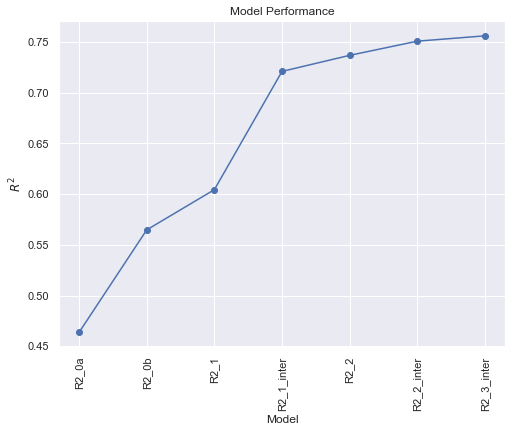

In [41]:
plt.figure(figsize=[8,6])
x= np.arange(0,7,1)
plt.plot(x,R2,'-ob')

xTick_label =  ['R2_0a', 'R2_0b',  'R2_1', 'R2_1_inter', 'R2_2', 'R2_2_inter', 'R2_3_inter'] 
plt.xticks(x,xTick_label, rotation ='vertical') 
plt.ylabel('$R^2$')
plt.xlabel('Model')
plt.title('Model Performance')

We observe that including the interaction term the performance jumps from ~60% to ~72%. Including higher polynomial terms we do not notice a significant improvement. Hence, the best model is the first order polynomial with interaction term. 

Here, we do not suggest a method for selecting the best model, just introduce the concept. We will be covering cross validation in depth next section!


## Bootstrapping

#### What is a confidence interval?

A confidence interval is a range of values that is likely to include a parameter of interest with some degree of certainty or "confidence."

#### How do we interpret 95% confidence intervals?

If we were to compute 95% confidence intervals for each of K repeated samples, we would expect 0.95\*K of those confidence intervals to contain the true parameter of interest.

#### What is bootstrapping?

Bootstrapping is a procedure for resampling a dataset with replacement to produce a **distribution** of the value of interest.

Using the model we selected from above, let's do some bootstrapping to generate the confidence intervals for our coefficients!

In [42]:
model_boston_1_inter.coef_

array([ 2.1321553 ,  9.56301377, -0.47503991])

In [43]:
print("Let's check out the coefficients of R2_1_inter")
for i in range(3):
    print("Beta"+str(i),":",model_boston_1_inter.coef_[i])


Let's check out the coefficients of R2_1_inter
Beta0 : 2.1321552984212175
Beta1 : 9.563013774758915
Beta2 : -0.47503991266831685


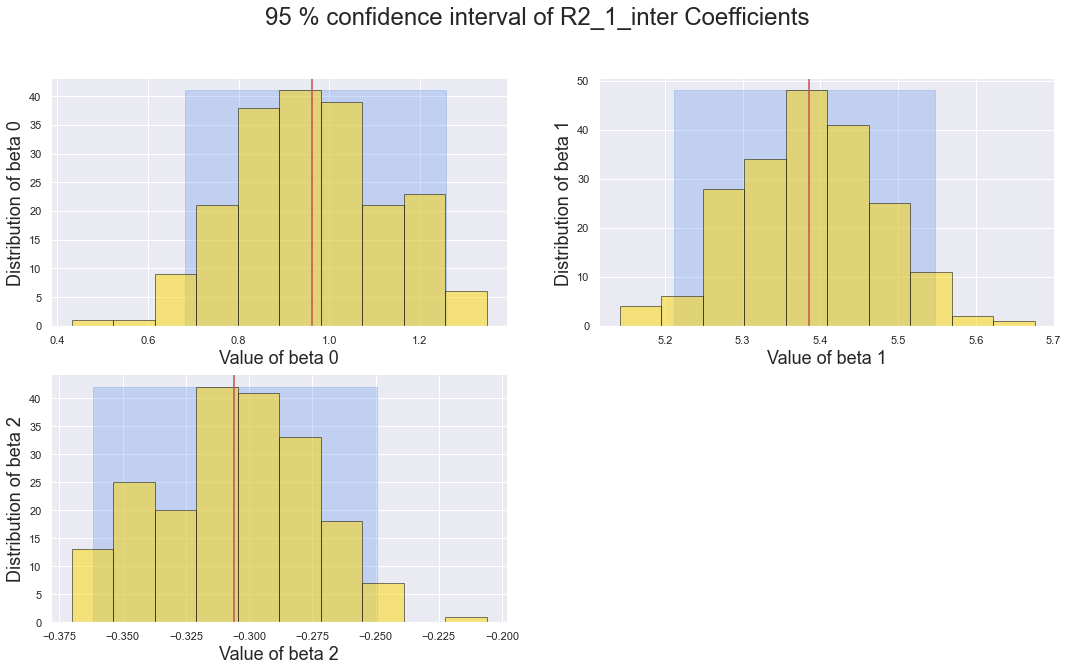

In [44]:
# number of bootstraps

bootstrap = []
numboot = 200

for i in range(numboot):
    boston_sampled = boston.sample(frac=1, replace=True)
    boston_sampled["LSTAT*RM"] = boston_sampled["LSTAT"]*boston_sampled["RM"]
    model_boston_1_inter = LinearRegression(fit_intercept=False).fit(boston_sampled[["LSTAT", "RM", "LSTAT*RM"]], boston_sampled.MEDV)
    bootstrap.append(model_boston_1_inter.coef_)

bootstrap = np.array(bootstrap)

fig, ax = plt.subplots(2,2, figsize = (18,10))
ax = ax.ravel()
for i in range(3):
    betavals = bootstrap[:,i]
    betavals.sort()
    x1 = np.percentile(betavals,2.5)
    x2 = np.percentile(betavals,97.5)
    x = np.linspace(x1,x2,500)
    counts, bins = np.histogram(betavals)
    y = counts.max()
    ax[i].hist(bootstrap[:,i], bins = 10, color="gold",alpha=0.5,edgecolor='black', linewidth=1)
    ax[i].fill_between(x,y, color = 'cornflowerblue',alpha=0.3)
    ax[i].set_ylabel(f'Distribution of beta {i}',fontsize=18)
    ax[i].set_xlabel(f'Value of beta {i}',fontsize=18)
    ax[i].axvline(x = np.mean(betavals), color='r')

fig.delaxes(ax[3])
fig.suptitle(f'95 % confidence interval of R2_1_inter Coefficients', fontsize = 24)
sns.despine()

## Regression Assumptions

![linear regression](../fig/linear_regression.png)

The answer to this question can be found on closer examimation of $\epsilon$. What is $\epsilon$? It is assumed that $\epsilon$ is normally distributed with a mean of 0 and variance $\sigma^2$. But what does this tell us?

1. Assumption 1: **Linearity** This is an implicit assumption as we claim that Y can be modeled through a linear combination of the predictors.
3. Assumption 2: **Independence of observations** This comes from the randomness of $\epsilon$.

2. Assumption 3: **Constant variance of $\epsilon$ errors** This means that if we plot our **residuals**, which are the differences between the true $Y$ and our predicted $\hat{Y}$, they should look like they have constant variance and a mean of 0.
4. Assumption 4: **Normality** We assume that the $\epsilon$ is normally distributed, and we can show this in a histogram of the residuals.

Mean of residuals: 1.1414341136708437e-14


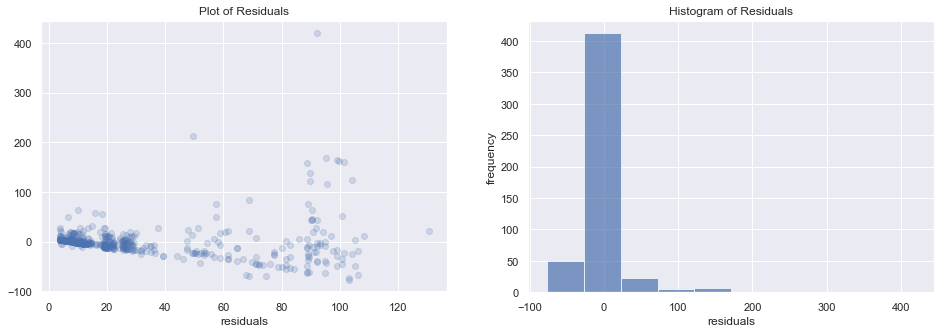

In [45]:
y_hat = model_5.predict(X_train)
residuals = titanic_train['fare'] - y_hat

# plotting
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax = ax.ravel()
ax[0].set_title('Plot of Residuals')
ax[0].scatter(y_hat, residuals, alpha=0.2)
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_xlabel('residuals')

ax[1].set_title('Histogram of Residuals')
ax[1].hist(residuals, alpha=0.7)
ax[1].set_xlabel('residuals')
ax[1].set_ylabel('frequency');

# Mean of residuals
print('Mean of residuals: {}'.format(np.mean(residuals)))

What can you say about the assumptions of the model?

Real data violate assumptions. So why use linear regression? Because linear regression has an analytical solution, so we guaranteed to find the optimal solutions and the solutions are computationally cheap to obtain. 

----------------
### End of Standard Section
---------------

## Extra: Visual exploration of predictors'  correlations

The dataset for this problem contains 10 simulated predictors and a response variable. 

In [46]:
# read in the data 
data = pd.read_csv('../data/dataset3.txt')
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.488866,0.488866,0.488866,0.078913,0.098292,0.144871,0.065302,0.250225,-0.392509,-0.501255,0.625915
1,0.146479,0.146479,0.146479,0.022562,0.088052,0.104879,0.082436,0.332836,-0.178366,-0.061798,0.058947
2,0.525450,0.525450,0.525450,-0.157520,-0.328685,-0.246146,-0.233882,0.054153,-0.010547,0.393186,-0.176577
3,0.351241,0.351241,0.351241,-0.062256,-0.096287,-0.033425,-0.088843,-0.475510,-0.066429,-0.249999,0.154168
4,-0.168068,-0.168068,-0.168068,-0.080250,-0.155529,-0.099511,-0.106430,-0.203144,0.194485,-0.037681,-0.288597


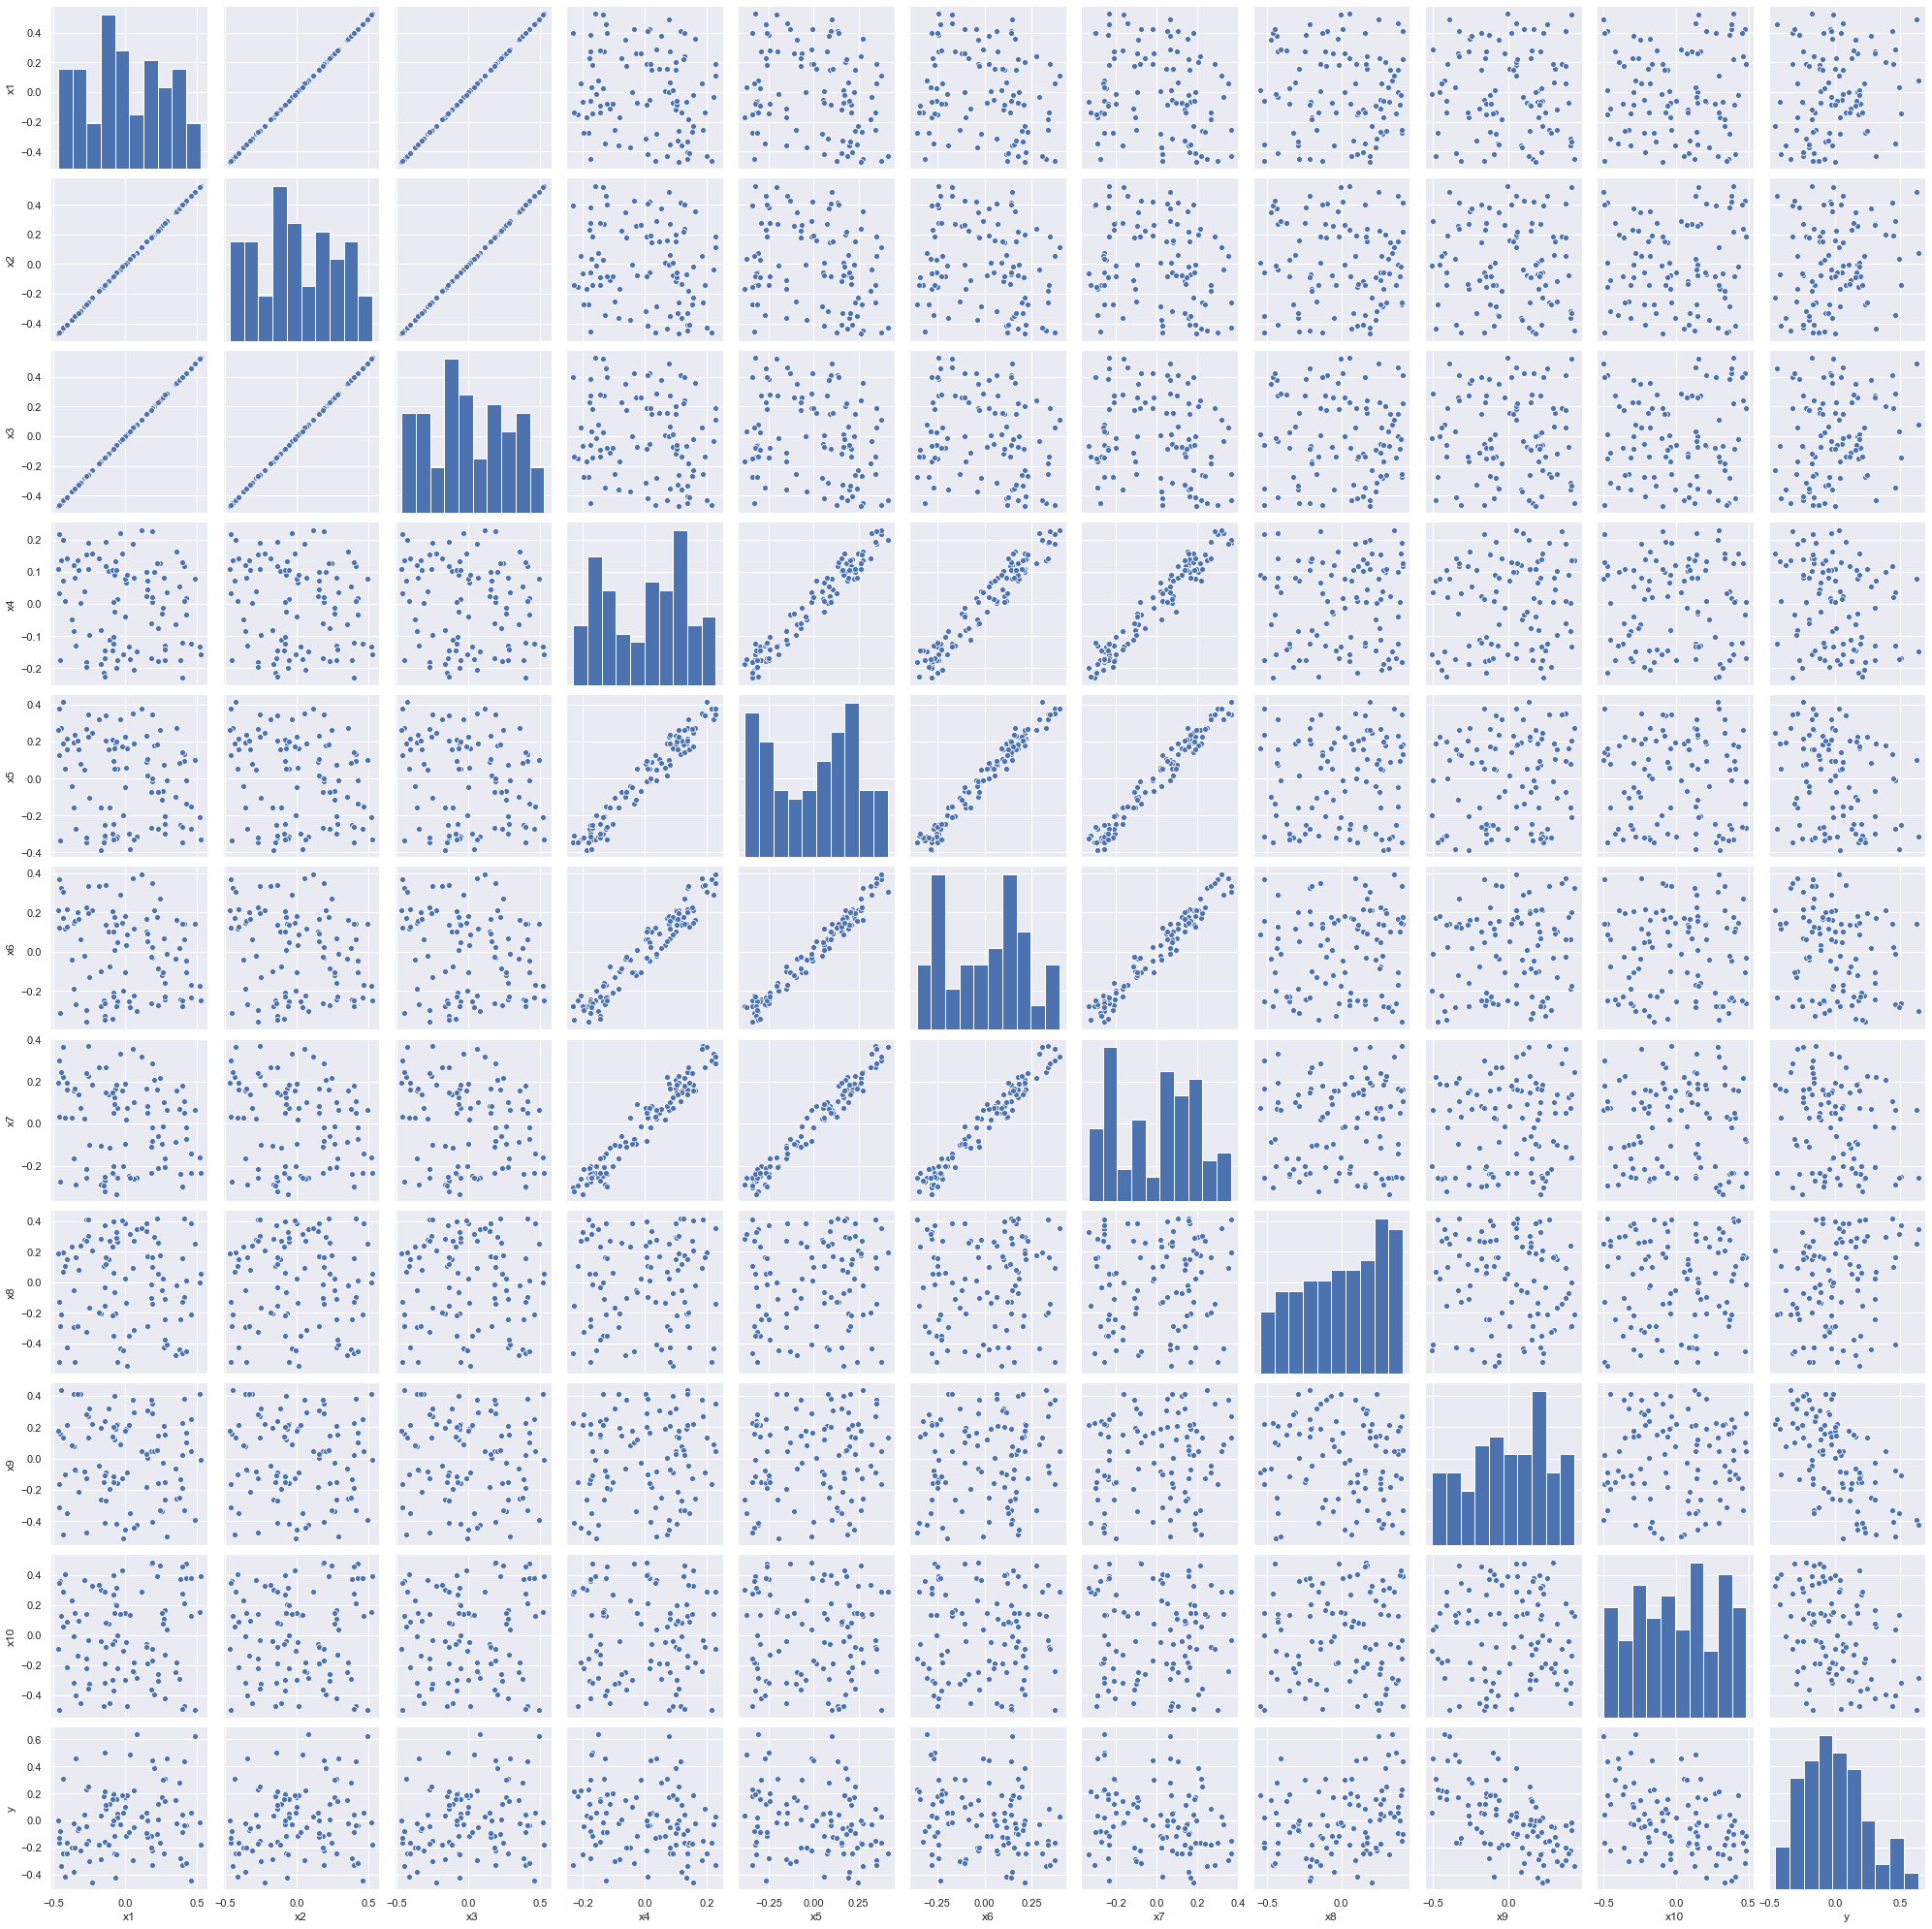

In [47]:
# this effect can be replicated using the scatter_matrix function in pandas plotting
sns.pairplot(data);

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 seem correlated.

In [48]:
data.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
x1,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x2,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x3,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x4,-0.189945,-0.189945,-0.189945,1.000000,0.974279,0.964344,0.969540,0.058516,0.108294,-0.010416,-0.225856
x5,-0.232439,-0.232439,-0.232439,0.974279,1.000000,0.982785,0.982227,0.080342,0.126004,-0.012399,-0.257433
x6,-0.215623,-0.215623,-0.215623,0.964344,0.982785,1.000000,0.976308,0.079547,0.123368,-0.021029,-0.261228
x7,-0.228322,-0.228322,-0.228322,0.969540,0.982227,0.976308,1.000000,0.074004,0.112241,-0.022023,-0.235921
x8,-0.047643,-0.047643,-0.047643,0.058516,0.080342,0.079547,0.074004,1.000000,-0.133182,0.052151,0.238538
x9,-0.061022,-0.061022,-0.061022,0.108294,0.126004,0.123368,0.112241,-0.133182,1.000000,0.006923,-0.607845
x10,0.050977,0.050977,0.050977,-0.010416,-0.012399,-0.021029,-0.022023,0.052151,0.006923,1.000000,-0.406231


<AxesSubplot:>

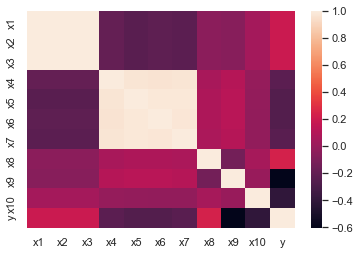

In [49]:
sns.heatmap(data.corr())

## Extra: A Handy Matplotlib Guide

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

See also [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.

![violin plot](../fig/violin.png)

See also [this](https://mode.com/blog/violin-plot-examples) violin plot tutorial.

### Using statsmodel OLS

**Exercise**: You've done this before: make a simple model using the OLS package from the statsmodels library predicting **fare** using **age** using the training data. Name your model `model_1` and display the summary

In [50]:
from statsmodels.api import OLS
import statsmodels.api as sm

In [51]:
age_ca = sm.add_constant(titanic_train['age'])
model_1 = OLS(titanic_train['fare'], age_ca).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.556
Date:                Fri, 25 Sep 2020   Prob (F-statistic):             0.0333
Time:                        20:26:42   Log-Likelihood:                -2621.6
No. Observations:                 498   AIC:                             5247.
Df Residuals:                     496   BIC:                             5256.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7657      4.777      4.766      0.000      13.381      32.151
age            0.3072      0.144      2.134      0.033       0.024       0.590
==============================================================================
Omnibus:                      494.474   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18897.650
Skew:                           4.428   Prob(JB):                         0.00
Kurtosis:                      31.850   Cond. No.                         75.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model_2 = sm.OLS(titanic_train['fare'], 
                 sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third']])).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     84.16
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           1.92e-54
Time:                        20:26:42   Log-Likelihood:                -2494.3
No. Observations:                 498   AIC:                             4999.
Df Residuals:                     493   BIC:                             5020.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          101.4571      5.710     17.768      0.000      90.238     112.677
age             -0.3439      0.124     -2.784      0.006      -0.587      -0.101
sex_male       -15.3974      3.507     -4.390      0.000     -22.289      -8.506
class_Second   -62.0175      4.720    -13.138      0.000     -71.292     -52.743
class_Third    -69.1698      4.351    -15.899      0.000     -77.718     -60.622
==============================================================================
Omnibus:                      542.916   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40564.443
Skew:                           4.859   Prob(JB):                         0.00
Kurtosis:                      46.133   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
titanic_train['sex_male_X_age'] = titanic_train['age'] * titanic_train['sex_male']

model_3 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     69.54
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           6.07e-55
Time:                        20:26:42   Log-Likelihood:                -2490.8
No. Observations:                 498   AIC:                             4994.
Df Residuals:                     492   BIC:                             5019.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             89.6508      7.226     12.407      0.000      75.454     103.848
age                0.0956      0.207      0.462      0.644      -0.311       0.502
sex_male           2.6594      7.676      0.346      0.729     -12.422      17.741
class_Second     -62.4182      4.694    -13.296      0.000     -71.642     -53.195
class_Third      -68.9649      4.325    -15.945      0.000     -77.463     -60.467
sex_male_X_age    -0.6390      0.242     -2.640      0.009      -1.114      -0.163
==============================================================================
Omnibus:                      542.930   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40612.905
Skew:                           4.859   Prob(JB):                         0.00
Kurtosis:                      46.160   Cond. No.                         246.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic_train['sex_male_X_class_Second'] = titanic_train['age'] * titanic_train['class_Second']
titanic_train['sex_male_X_class_Third'] = titanic_train['age'] * titanic_train['class_Third']

model_4 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     51.06
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           1.74e-54
Time:                        20:26:42   Log-Likelihood:                -2487.5
No. Observations:                 498   AIC:                             4991.
Df Residuals:                     490   BIC:                             5025.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     108.9729     10.439     10.439      0.000      88.462     129.484
age                        -0.4305      0.291     -1.478      0.140      -1.003       0.142
sex_male                    1.1153      7.671      0.145      0.884     -13.958      16.188
class_Second              -86.5187     11.906     -7.267      0.000    -109.911     -63.126
class_Third               -92.2991     10.458     -8.825      0.000    -112.848     -71.750
sex_male_X_age             -0.5652      0.243     -2.330      0.020      -1.042      -0.088
sex_male_X_class_Second     0.6703      0.320      2.094      0.037       0.041       1.299
sex_male_X_class_Third      0.6730      0.286      2.355      0.019       0.111       1.235
==============================================================================
Omnibus:                      544.096   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41994.711
Skew:                           4.863   Prob(JB):                         0.00
Kurtosis:                      46.923   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean of residuals: 7.307461195720741e-13


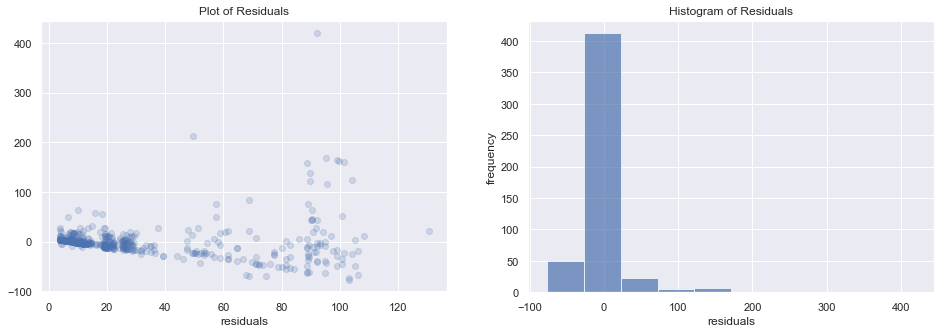

In [55]:
titanic_train['age^2'] = titanic_train['age']**2

model_5 = sm.OLS(
    titanic_train['fare'],
    sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                             'sex_male_X_class_Second', 'sex_male_X_class_Third', 'age^2']])
).fit()
model_5.summary()

predictors = sm.add_constant(titanic_train[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 
                                      'sex_male_X_class_Second', 'sex_male_X_class_Third', 'age^2']])
y_hat = model_5.predict(predictors)
residuals = titanic_train['fare'] - y_hat

# plotting
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax = ax.ravel()
ax[0].set_title('Plot of Residuals')
ax[0].scatter(y_hat, residuals, alpha=0.2)
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_xlabel('residuals')

ax[1].set_title('Histogram of Residuals')
ax[1].hist(residuals, alpha=0.7)
ax[1].set_xlabel('residuals')
ax[1].set_ylabel('frequency');

# Mean of residuals
print('Mean of residuals: {}'.format(np.mean(residuals)))

---